In [1]:
from pyiron_atomistics import Project

In [35]:
import numpy as np

In [36]:
import matplotlib.pyplot as plt

# Finding Unit Cells Via Radon Transforms

## Develop an intuition

1. Given a 3D crystal in a viewer, how do you orient it for yourself? 
2. How does that correspond to the lattice?
3. How would that generalize to an automatic algorithm?

Let's watch some atoms with ovito or pyiron here.

In [2]:
pr = Project('.')

In [3]:
bulk = pr.create.structure.bulk('Mg', orthorhombic=True).repeat(5)

In [4]:
bulk.plot3d()

NGLWidget()

## Some Code the learn how to process images

In [5]:
import PIL

In [6]:
!wget 'https://avatars.githubusercontent.com/u/2719909?v=4' -O logo.png

--2023-09-19 08:14:12--  https://avatars.githubusercontent.com/u/2719909?v=4
Resolving avatars.githubusercontent.com (avatars.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to avatars.githubusercontent.com (avatars.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5131 (5.0K) [image/jpeg]
Saving to: ‘logo.png’

logo.png            100%[===================>]   5.01K  --.-KB/s    in 0s      

2023-09-19 08:14:12 (24.3 MB/s) - ‘logo.png’ saved [5131/5131]



In [7]:
from PIL import Image

In [8]:
img = Image.open('logo.png')

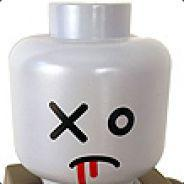

In [9]:
img

In [10]:
r = img.rotate(17, expand=True)

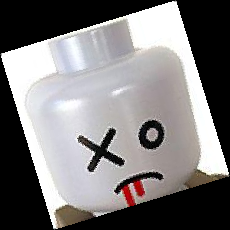

In [11]:
r

In [12]:
r.size

(230, 230)

We can export pictures like this into arrays.

In [14]:
d = np.array(r)

In [15]:
d

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

Let's generate a fake TEM image and try out intuition.

In [16]:
from msiplib.emic import generate_crystal_image

In [27]:
c = generate_crystal_image()

In [28]:
c *= 255 / c.max()

In [29]:
cimg = Image.fromarray( c ).convert('L')

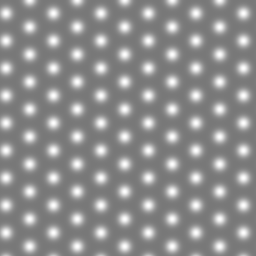

In [30]:
cimg

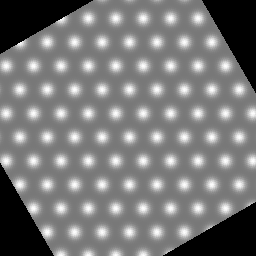

In [31]:
cimg.rotate(30)

In [37]:
def projected(img):
    d = np.array( img )
    return d.sum(axis=-1)

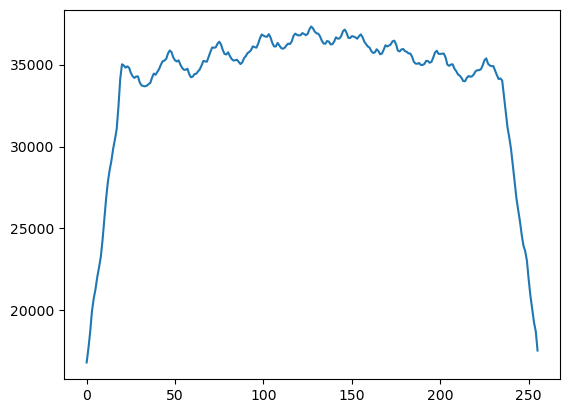

In [39]:
plt.plot( projected(cimg.rotate(10)) )

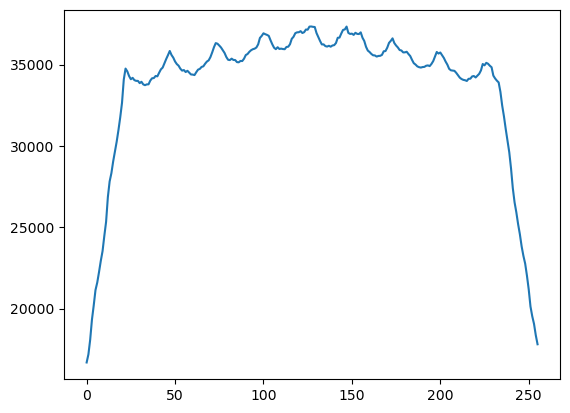

In [42]:
plt.plot( projected(cimg.rotate(11)) )

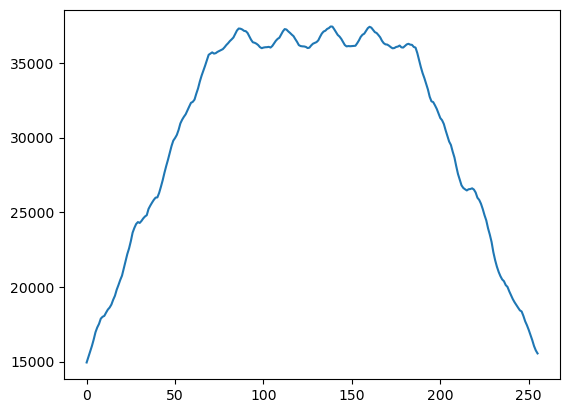

In [43]:
plt.plot( projected(cimg.rotate(42)) )

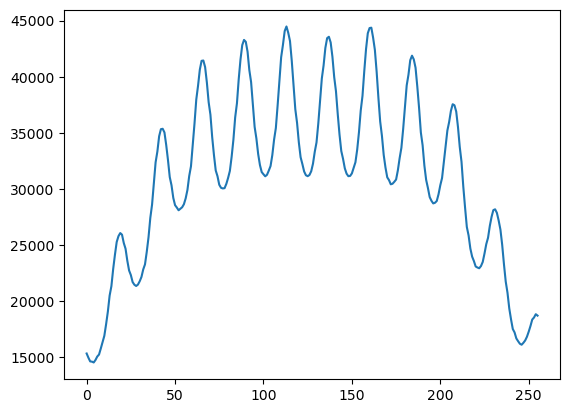

In [44]:
plt.plot( projected(cimg.rotate(30)) )

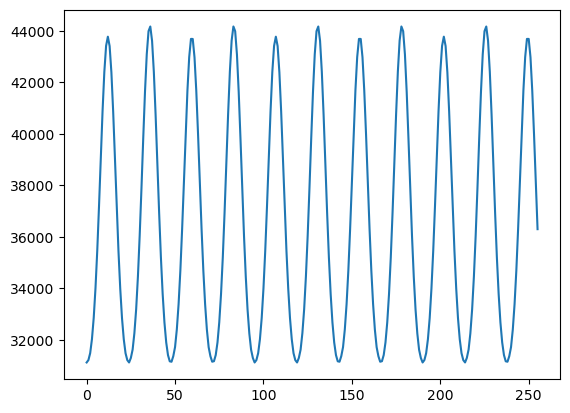

In [45]:
plt.plot( projected(cimg.rotate(90)) )

Seems that there are special rotation that make the plot more "regular".

In [46]:
def radon(img):
    thetas = np.linspace(0, 90, 180)
    s = [projected(img.rotate(t)).std() for t in thetas]
    return thetas, np.array(s)

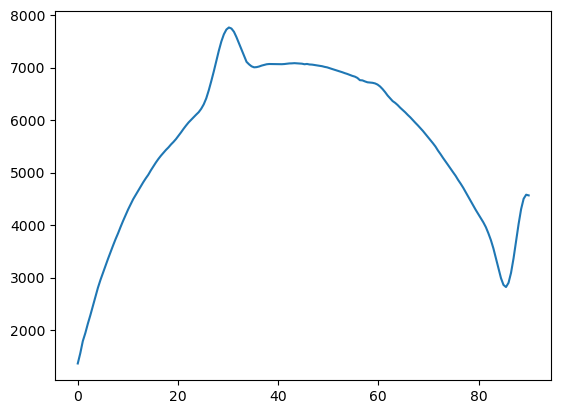

In [47]:
plt.plot( *radon(cimg) )

Promising! But has this weird parabola shape?

In [48]:
white = Image.fromarray( 255*np.ones(cimg.size) ).convert('L')

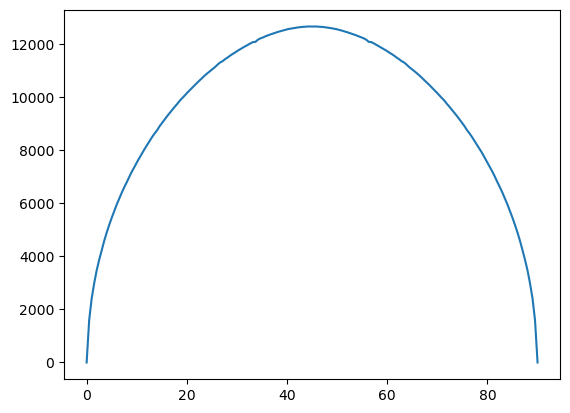

In [49]:
plt.plot( *radon(white) )

Aha! Rotating alone introduces this weird dependance.

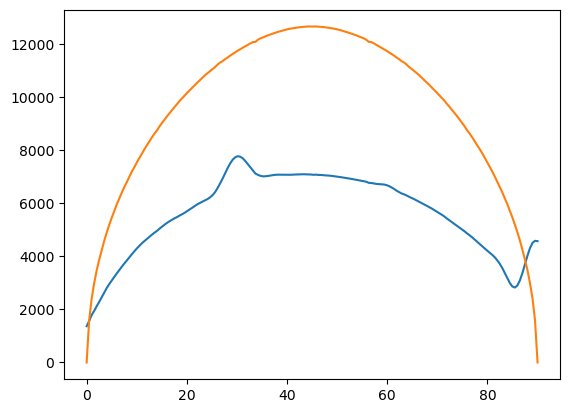

In [50]:
plt.plot( *radon(cimg) )
plt.plot( *radon(white) )

Solutions?

In [51]:
def projected(img, filter):
    d = np.array( img ).T
    f = np.array( filter ).T
    s = []
    for dl, fl in zip(d, f):
        s.append(dl[fl==255].std())
    return np.array(s)

In [52]:
def radon(img, filter=None, steps=180):
    if filter is None:
        filter = Image.fromarray( np.full(img.size, 255.0) )
    thetas = np.linspace(0, 180, steps)
    s = [projected(img.rotate(t), filter.rotate(t)).std() for t in thetas]
    return thetas, np.array(s)

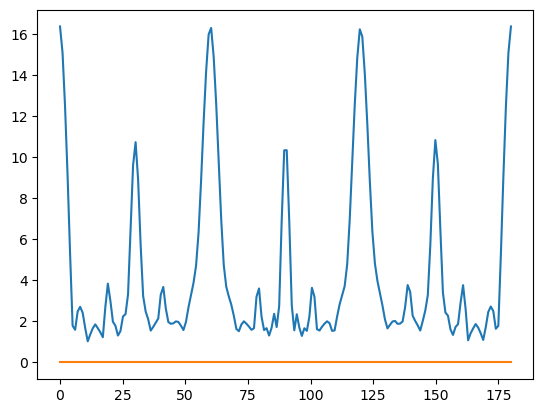

In [53]:
plt.plot( *radon(cimg) )
plt.plot( *radon(white) )

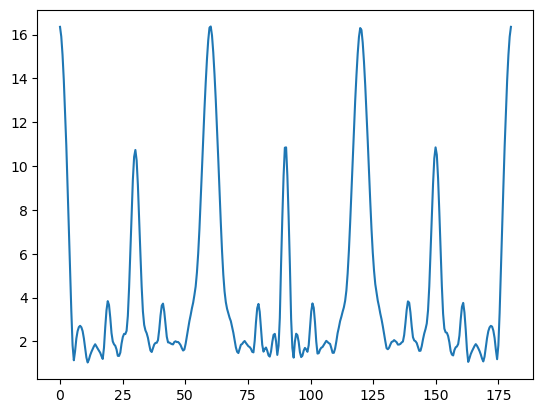

In [54]:
plt.plot( *radon(cimg, steps=360) )

Peaks here are where the standard deviation of the sineogram is large, i.e. where rotated the image such that the pixel values change a lot, indicating that it is along a lattice vector.

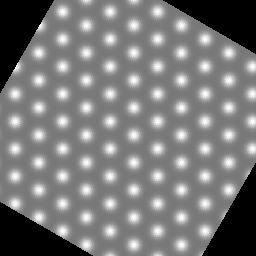

In [55]:
cimg.rotate(60)

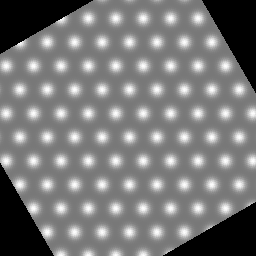

In [56]:
cimg.rotate(30)

By eye we can identify 0, 30, 60 and 90.  Can we automate this?

In [57]:
import scipy.signal as si

In [58]:
si.find_peaks?

Signature:
si.find_peaks(
    x,
    height=None,
    threshold=None,
    distance=None,
    prominence=None,
    width=None,
    wlen=None,
    rel_height=0.5,
    plateau_size=None,
)
Docstring:
Find peaks inside a signal based on peak properties.

This function takes a 1-D array and finds all local maxima by
simple comparison of neighboring values. Optionally, a subset of these
peaks can be selected by specifying conditions for a peak's properties.

Parameters
----------
x : sequence
    A signal with peaks.
height : number or ndarray or sequence, optional
    Required height of peaks. Either a number, ``None``, an array matching
    `x` or a 2-element sequence of the former. The first element is
    always interpreted as the  minimal and the second, if supplied, as the
    maximal required height.
threshold : number or ndarray or sequence, optional
    Required threshold of peaks, the vertical distance to its neighboring
    samples. Either a number, ``None``, an array matching `x`

In [59]:
theta, radon_img = radon(cimg, steps=360+1)

In [60]:
peaks, _ = si.find_peaks(radon_img)

In [61]:
theta[peaks]

array([  8. ,  14. ,  19. ,  25.5,  30. ,  38. ,  41. ,  46.5,  60. ,
        73.5,  79. ,  82. ,  85.5,  90. ,  94.5,  98. , 101. , 106.5,
       120. , 133.5, 139. , 150. , 161. , 166. , 172. ])

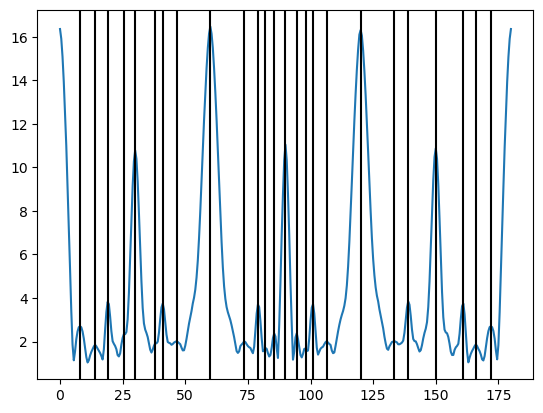

In [62]:
plt.plot(theta, radon_img)
for t in theta[peaks]:
    plt.axvline(t, color='k')

You can play if the parameters if you think it finds too much or little peaks.  Parameters include the relative height to the background, the absolute height or a minimum distance to other peaks.

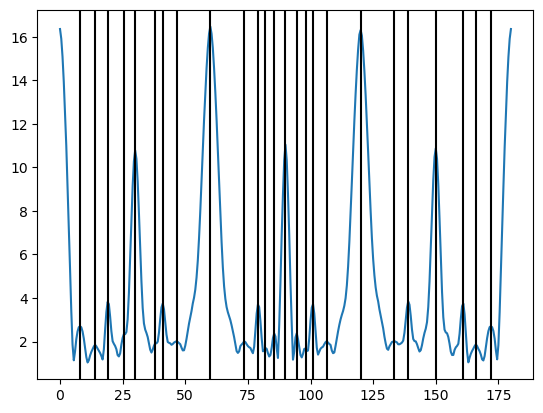

In [63]:
peaks, _ = si.find_peaks(radon_img, distance=5)
plt.plot(theta, radon_img)
for t in theta[peaks]:
    plt.axvline(t, color='k')

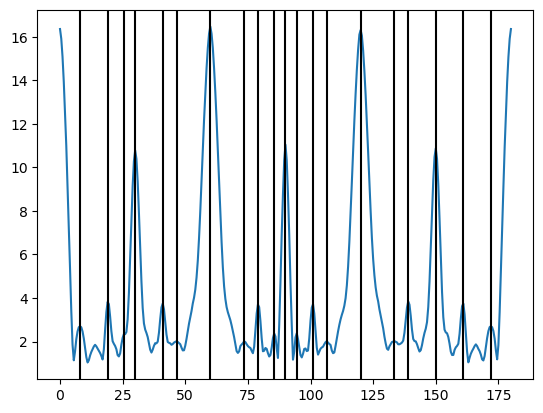

In [64]:
peaks, _ = si.find_peaks(radon_img, height=2, distance=5)
plt.plot(theta, radon_img)
for t in theta[peaks]:
    plt.axvline(t, color='k')

In [65]:
theta[peaks]

array([  8. ,  19. ,  25.5,  30. ,  41. ,  46.5,  60. ,  73.5,  79. ,
        85.5,  90. ,  94.5, 101. , 106.5, 120. , 133.5, 139. , 150. ,
       161. , 172. ])

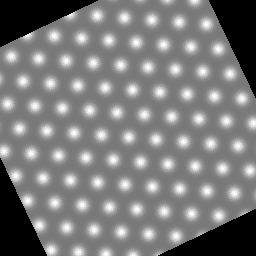

In [66]:
cimg.rotate(25.5)

Visually we can confirm that this finds lattice vectors, but can we get their length automatically?

In [67]:
import skimage as ski

In [68]:
ski.transform.radon?

Signature:
ski.transform.radon(
    image,
    theta=None,
    circle=True,
    *,
    preserve_range=False,
)
Docstring:
Calculates the radon transform of an image given specified
projection angles.

Parameters
----------
image : array_like
    Input image. The rotation axis will be located in the pixel with
    indices ``(image.shape[0] // 2, image.shape[1] // 2)``.
theta : array_like, optional
    Projection angles (in degrees). If `None`, the value is set to
    np.arange(180).
circle : boolean, optional
    Assume image is zero outside the inscribed circle, making the
    width of each projection (the first dimension of the sinogram)
    equal to ``min(image.shape)``.
preserve_range : bool, optional
    Whether to keep the original range of values. Otherwise, the input
    image is converted according to the conventions of `img_as_float`.
    Also see https://scikit-image.org/docs/dev/user_guide/data_types.html

Returns
-------
radon_image : ndarray
    Radon transform (sinogram).

In [69]:
x = ski.transform.radon(np.array( cimg.getdata() ).reshape(cimg.size), circle=True, theta=theta)

/srv/conda/envs/notebook/lib/python3.11/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


In [70]:
w = ski.transform.radon(np.array( white.getdata() ).reshape(white.size), circle=True, theta=theta)

In [71]:
x.shape, w.shape

((256, 361), (256, 361))

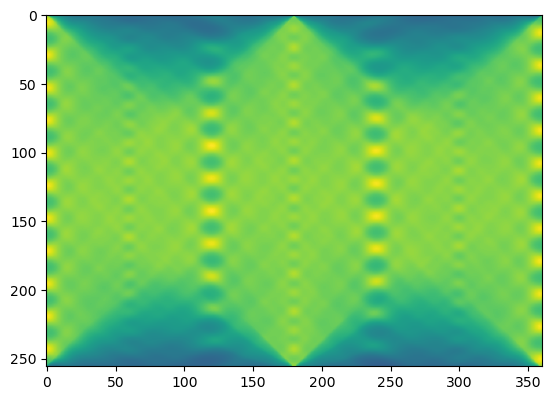

In [72]:
plt.imshow(x)

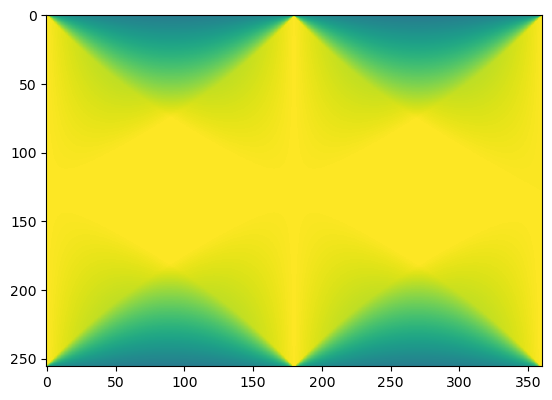

In [73]:
plt.imshow(w)

/tmp/ipykernel_112/684876193.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot( (x/w).std(axis=0), 'k-' )


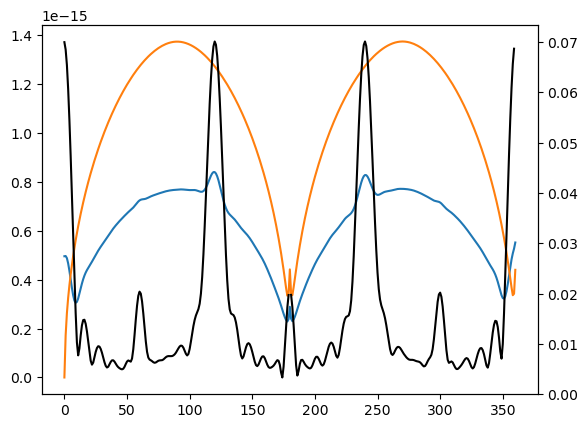

In [74]:
plt.plot(x.std(axis=0))
plt.plot(w.std(axis=0))
plt.twinx()
plt.plot( (x/w).std(axis=0), 'k-' )

Compare to "manual" method.

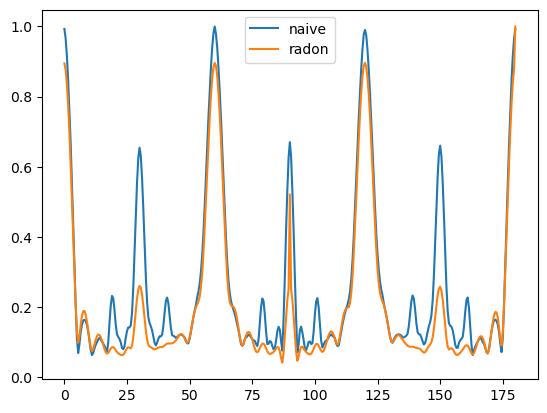

In [77]:
plt.plot(theta, radon_img/radon_img.max(), label='naive')
radon_ski = (x/np.clip(w, 1e-15, 1)).std(axis=0)
radon_ski /= radon_ski.max()
plt.plot(theta, radon_ski, label='radon')
plt.legend()

In [78]:
peaks_ski, _ = si.find_peaks(radon_ski)

In [79]:
theta[peaks_ski]

array([  8. ,  13.5,  19.5,  25.5,  30. ,  41.5,  46.5,  60. ,  73.5,
        79.5,  85. ,  90. ,  95. , 101. , 106.5, 120. , 133.5, 150. ,
       154.5, 160.5, 166.5, 172. ])

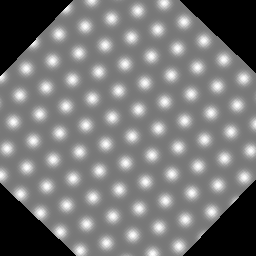

In [80]:
cimg.rotate(46.5)